In [2]:
import pandas as pd
import numpy as np
import ast
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_pickle('data/model_data_window_500_space_50.pkl')
df.head()

,id,sig_array,activity_name,subject_id,dataset
0,0,"[[-0.1832595, -0.2076941, -0.53145254, 9.77168...",squats,0,mmfit
1,1,"[[1.502728, -1.7263045, -1.4062113, 0.86939216...",squats,0,mmfit
2,2,"[[-0.21502449, -1.5980228, -1.4941758, 6.47373...",non-e,0,mmfit
3,3,"[[0.6059781, 0.07819072, -0.53633946, 7.046148...",non-e,0,mmfit
4,4,"[[0.09896013, -0.2724458, 0.53145254, 1.087338...",non-e,0,mmfit


In [5]:
name_fix_dict = {'non-e' : 'rest',
                 'nonexercise': 'rest',
                 'staticstretch(atyourownpace)': 'staticstretch',
                 'two-armdumbbellcurl(botharms,notalternating)': 'bicepcurls',
                 'wallballs': 'wallball',
                 'dumbbell_shoulder_press': 'dumbbellshoulderpress',
                 'lateral_shoulder_raises': 'lateralshoulderraises',
                 'sit-up(handspositionedbehindhead)': 'situps'}


df['activity_name'] = df['activity_name'].apply(lambda x: name_fix_dict[x] if x in name_fix_dict.keys() else x)

In [6]:
df['activity_name'].unique()

array(['squats', 'rest', 'pushups', 'dumbbellshoulderpress', 'lunges',
       'dumbbell_rows', 'situps', 'bicep_curls', 'lateralshoulderraises',
       'tricep_extensions', 'jumping_jacks', 'kbpress', 'boxjumps',
       'deadlifts', 'crunches', 'kbsquatpress', 'null', 'wallball',
       'burpees', 'pullups', 'bicepscurl(band)', 'ellipticalmachine',
       'staticstretch', 'burpee', 'bicepcurls',
       'dynamicstretch(atyourownpace)', 'walk', 'tricepextensions', 'dip',
       'plank', 'v-up', 'dumbbellrows', 'deviceontable',
       'kettlebellswing', 'russiantwist', 'crunch', 'seatedbackfly',
       'butterflysit-up', 'jumprope', 'fastalternatingpunches',
       'sideplankrightside', 'sideplankleftside', 'note',
       'taprightdevice', 'repetitivestretching', 'jumpingjacks',
       'powerboatpose', 'tapleftdevice', 'unlistedexercise',
       'running(treadmill)', 'armbandadjustment',
       'overheadtricepsextension(labelspansbotharms)', 'bandpull-downrow',
       'chestpress(rack)', 

In [7]:
df[df['activity_name']=='null']['dataset'].unique()

array(['har_data'], dtype=object)

In [8]:
# limit to labels with enough examples

counts = df['activity_name'].value_counts()
valid_activities = [activity for activity in counts.index.tolist() if counts[activity] >=1000]
df = df[df['activity_name'].isin(valid_activities)]

print(f"There are {len(df['activity_name'].unique())} unique activities in the dataset")

There are 33 unique activities in the dataset


In [9]:
# Create test train val split on the user level

# split test/train
train_users, test_users = train_test_split(df['subject_id'].unique(), train_size=.8, random_state=42)

train_data = df[df['subject_id'].isin(train_users)]
test_data = df[df['subject_id'].isin(test_users)]

# split train/val
train_users, val_users = train_test_split(train_data['subject_id'].unique(), train_size=.9, random_state=42)

val_data = train_data[train_data['subject_id'].isin(val_users)]
train_data = train_data[train_data['subject_id'].isin(train_users)]

print("The Sizes of the Train, Test, and Val Sets are:")
print(f"Train Size: {len(train_data)}")
print(f"Test Size: {len(test_data)}")
print(f"Val Size: {len(val_data)}")

The Sizes of the Train, Test, and Val Sets are:
Train Size: 102901
Test Size: 28716
Val Size: 9575


In [10]:
# Seperate X and Y components of data

X_train = np.array(train_data['sig_array'])
X_test = np.array(test_data['sig_array'])
X_Val = np.array(val_data['sig_array'])

y_train = np.array(train_data['activity_name'])
y_test = np.array(test_data['activity_name'])
y_val = np.array(val_data['activity_name'])

In [11]:
# Get Data in right format

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)


X_train = np.stack(X_train).astype(np.float32)
X_test = np.stack(X_test).astype(np.float32)
X_Val = np.stack(X_Val).astype(np.float32)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_Val_tensor = torch.tensor(X_Val, dtype=torch.float32)

# Convert y arrays to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

In [12]:
from torch.utils.data import Dataset, DataLoader

class IMUDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # Convert to tensor and swap axes
        self.y = torch.tensor(y, dtype=torch.long)  # Ensure labels are integers for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset Objects
train_dataset = IMUDataset(X_train, y_train_encoded)
val_dataset = IMUDataset(X_Val, y_val_encoded)
test_dataset = IMUDataset(X_test, y_test_encoded)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return 100 * correct / total

<module 'model' from '/Users/jacobgottesman/Public/DS 4440/smartwatch-activity-recognition/model.py'>

In [39]:

import torch.optim as optim
import torch.nn as nn

from model import *


# Model setup
num_classes = len(np.unique(y_train_encoded))
window_length = 500  
device = torch.device("mps" if torch.mps.is_available() else "cpu")

model = IMUCNN(num_classes=num_classes, window_length=window_length).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
augmenter = TimeSeriesAugmentation()


# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:

        X_batch = augmenter.apply(X_batch)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    #  Compute validation accuracy
    val_accuracy = compute_accuracy(model, val_loader, device)
    train_accuracy = compute_accuracy(model, train_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Train Accuracy {train_accuracy:.2f}%")


print("Training complete!")


Epoch [1/5], Loss: 1.1706, Val Accuracy: 78.98%, Train Accuracy 82.00%
Epoch [2/5], Loss: 0.6606, Val Accuracy: 85.89%, Train Accuracy 88.31%
Epoch [3/5], Loss: 0.5080, Val Accuracy: 89.70%, Train Accuracy 91.33%
Epoch [4/5], Loss: 0.4248, Val Accuracy: 88.16%, Train Accuracy 92.90%
Epoch [5/5], Loss: 0.3716, Val Accuracy: 88.92%, Train Accuracy 92.62%
Training complete!


In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predict(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Handle different possible dataloader formats
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                X_batch, y_batch = batch
            else:
                X_batch = batch
                y_batch = None  # For inference without labels

            # Move input to device
            X_batch = X_batch.to(device)
            
            # Ensure input has the right shape [batch_size, channels, time_steps]
            if len(X_batch.shape) == 2:
                # If input is [batch_size, features], reshape to [batch_size, channels, time_steps]
                # Assuming the first 6 features are the 6 channels we need
                channels = 6
                time_steps = X_batch.shape[1] // channels
                X_batch = X_batch.view(-1, channels, time_steps)
            
            # Forward pass
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            
            # Store predictions
            all_preds.extend(predicted.cpu().numpy())
            
            # Store labels if available
            if y_batch is not None:
                y_batch = y_batch.to(device)
                all_labels.extend(y_batch.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    
    # Return predictions and labels (if available)
    if len(all_labels) > 0:
        all_labels = np.array(all_labels)
        return all_preds, all_labels
    else:
        return all_preds

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """
    Plot confusion matrix with matplotlib and seaborn.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Generate a custom color map
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Draw the heatmap with seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                square=True, cbar_kws={"shrink": .8}, 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    # Set plot labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report if class names are provided
    if class_names is not None:
        print(classification_report(y_true, y_pred, target_names=class_names))

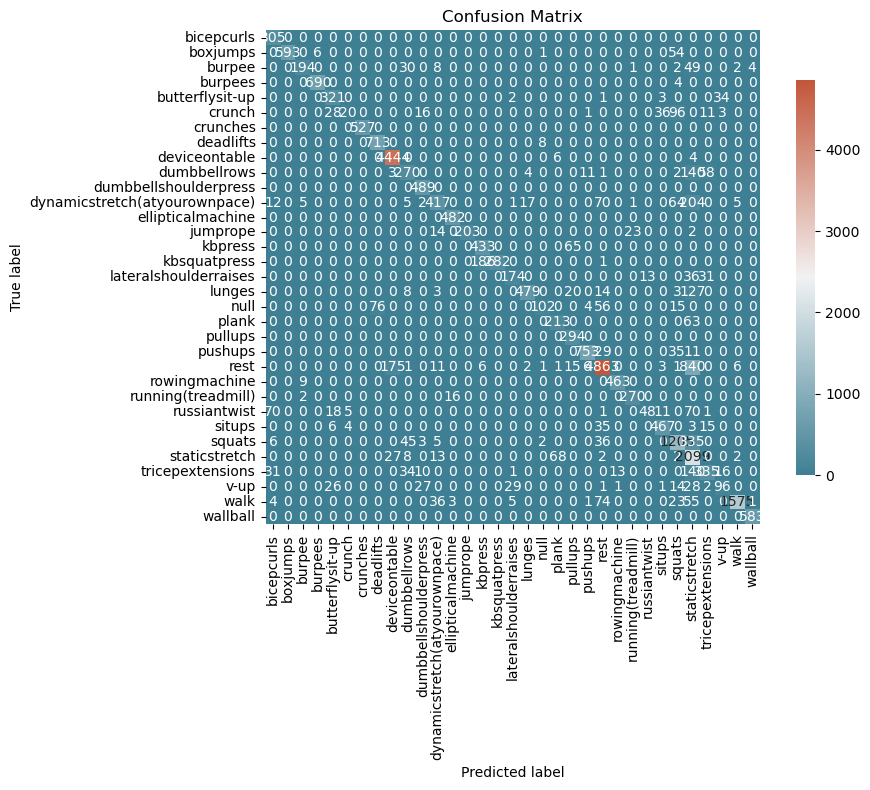

                               precision    recall  f1-score   support

                   bicepcurls       0.71      1.00      0.83       305
                     boxjumps       1.00      0.91      0.95       654
                       burpee       0.92      0.67      0.78       290
                      burpees       0.99      0.99      0.99       694
              butterflysit-up       0.80      0.89      0.84       361
                       crunch       0.69      0.09      0.17       211
                     crunches       1.00      1.00      1.00       527
                    deadlifts       0.90      0.99      0.94       721
                deviceontable       0.96      1.00      0.98      4454
                 dumbbellrows       0.67      0.55      0.61       489
        dumbbellshoulderpress       0.89      1.00      0.94       489
dynamicstretch(atyourownpace)       0.82      0.52      0.64       803
            ellipticalmachine       0.96      1.00      0.98       482
     

In [53]:
# For evaluation with labels
test_preds, test_labels = predict(model, test_loader, device)
plot_confusion_matrix(test_labels, test_preds, class_names=list(label_encoder.classes_))

# For inference without labels
# inference_preds = predict(model, inference_dataloader, device)

In [51]:
# Get predictions
y_pred, y_true = predict(model, val_loader, device)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)



# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, labels=list(label_encoder.classes_)))


Classification Report:
                                precision    recall  f1-score   support

                   bicepcurls       0.00      0.00      0.00         0
                     boxjumps       0.00      0.00      0.00         0
                       burpee       0.00      0.00      0.00         0
                      burpees       0.00      0.00      0.00         0
              butterflysit-up       0.00      0.00      0.00         0
                       crunch       0.00      0.00      0.00         0
                     crunches       0.00      0.00      0.00         0
                    deadlifts       0.00      0.00      0.00         0
                deviceontable       0.00      0.00      0.00         0
                 dumbbellrows       0.00      0.00      0.00         0
        dumbbellshoulderpress       0.00      0.00      0.00         0
dynamicstretch(atyourownpace)       0.00      0.00      0.00         0
            ellipticalmachine       0.00      0.00  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

In [46]:
model

IMUCNN(
  (conv1): Conv1d(6, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7936, out_features=500, bias=True)
  (bn_fc1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=64, 

In [32]:
label_encoder.classes_

array(['bicepcurls', 'boxjumps', 'burpee', 'burpees', 'butterflysit-up',
       'crunch', 'crunches', 'deadlifts', 'deviceontable', 'dumbbellrows',
       'dumbbellshoulderpress', 'dynamicstretch(atyourownpace)',
       'ellipticalmachine', 'jumprope', 'kbpress', 'kbsquatpress',
       'lateralshoulderraises', 'lunges', 'null', 'plank', 'pullups',
       'pushups', 'rest', 'rowingmachine', 'running(treadmill)',
       'russiantwist', 'situps', 'squats', 'staticstretch',
       'tricepextensions', 'v-up', 'walk', 'wallball'], dtype=object)